In [1]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

MAX_SEQ_LENGTH = 40
NUM_FEATURES = 2560

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 9537
Total videos for testing: 3783


,video_name,tag
4758,v_Knitting_g15_c03.avi,Knitting
1087,v_Billiards_g09_c01.avi,Billiards
5427,v_PizzaTossing_g08_c04.avi,PizzaTossing
6732,v_Punch_g15_c01.avi,Punch
1662,v_BoxingPunchingBag_g25_c02.avi,BoxingPunchingBag
4270,v_JavelinThrow_g11_c02.avi,JavelinThrow
4750,v_Knitting_g13_c05.avi,Knitting
7079,v_RopeClimbing_g11_c04.avi,RopeClimbing
8312,v_Surfing_g17_c06.avi,Surfing
1603,v_BoxingPunchingBag_g16_c02.avi,BoxingPunchingBag


In [4]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [5]:

def build_feature_extractor():
    feature_extractor = keras.applications.EfficientNetB7(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.efficientnet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

2022-07-05 13:49:40.060692: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-05 13:49:40.575861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'HammerThrow', 'Hammering', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'P

In [9]:
from tqdm import tqdm

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in tqdm(enumerate(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


# train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

# print(f"Frame features in train set: {train_data[0].shape}")
# print(f"Frame masks in train set: {train_data[1].shape}")

3783it [3:25:30,  3.26s/it]


In [11]:
train_data, train_labels = prepare_all_videos(train_df, "train")

9537it [8:48:08,  3.32s/it]


In [ ]:
# Utility for our sequence model.
# Bidirectional

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5))(#16, 512
        frame_features_input, mask=mask_input
    )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.LeakyReLU()(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.2,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

In [ ]:
#40.13% LSTM(2048,dropout=0.1)
#46.47% LSTM(2048,dropout=0.5)
#43.96% LSTM(4096,dropout=0.5)

In [ ]:
class_vocab = label_processor.get_vocabulary()

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.LSTM(2048, return_sequences=True,dropout=0.1)(#16, 512
    frame_features_input, mask=mask_input
)
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1024, activation="relu")(x)#8, 256
output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

rnn_model = keras.Model([frame_features_input, mask_input], output)

rnn_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

print(rnn_model.summary())

In [ ]:
class_vocab = label_processor.get_vocabulary()

frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

# Refer to the following tutorial to understand the significance of using `mask`:
# https://keras.io/api/layers/recurrent_layers/gru/
x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.1)(#16, 512
    frame_features_input, mask=mask_input
)
# x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(1024, activation="relu")(x)#8, 256
output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

rnn_model = keras.Model([frame_features_input, mask_input], output)

rnn_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

print(rnn_model.summary())

In [ ]:

def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
ls -l

In [ ]:
import numpy as np
import tensorflow as tf 

np.save('Inception_CNNRNN_train_data.npy', train_data)    # .npy extension is added if not given
# np.save('Inception_CNNRNN_test_data.npy', test_data[0])    # .npy extension is added if not given
# np.save('Inception_CNNRNN_train_labels.npy', train_data[1])    # .npy extension is added if not given
# np.save('Inception_CNNRNN_test_labels.npy', test_labels)    # .npy extension is added if not given

In [ ]:
print(train_data[0].shape)
print(train_data[1].shape)

In [ ]:
print(train_data.type)

In [12]:
import pickle

with open('EffB7_CNNRNN_train_40.pickle', 'wb') as f:
    pickle.dump(train_data, f)

In [10]:
import pickle

with open('EffB7_CNNRNN_test_40.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [ ]:
import numpy as np
import tensorflow as tf 

# np.save('densenet_train_data.npy', train_data)    # .npy extension is added if not given
# np.save('densenet_test_data.npy', test_data)    # .npy extension is added if not given
np.save('CNNRNN_train_labels.npy', train_labels)    # .npy extension is added if not given
np.save('CNNRNN_test_labels.npy', test_labels)    # .npy extension is added if not given

In [ ]:
ls -l

In [ ]:
mv Inception_CNNRNN_20.pickle Inception_CNNRNN_train_20.pickle

In [4]:
import numpy as np
import tensorflow as tf 
import pickle

with open('EffB7_CNNRNN_train_40.pickle', 'rb') as f:
     d_train_data = pickle.load(f)
with open('EffB7_CNNRNN_test_40.pickle', 'rb') as f:
     d_test_data = pickle.load(f)
        
# d_train_data = np.load('densenet_train_data.npy')
# d_test_data = np.load('densenet_test_data.npy')
d_train_labels = np.load('CNNRNN_train_labels.npy')
d_test_labels = np.load('CNNRNN_test_labels.npy')

In [5]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
# print(label_processor.get_vocabulary())

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.5)(#16, 512
        frame_features_input, mask=mask_input
    )    
#     x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5),merge_mode='concat')(#16, 512
#         frame_features_input, mask=mask_input
#     )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.GaussianNoise(0.4)(x)
    x = keras.layers.LeakyReLU(0.1)(x)    
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

#     rnn_model.compile(
#         loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
#     )
    return rnn_model

# Utility for running experiments.
def d_run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    
    optimizer = keras.optimizers.SGD(lr=1e-3)
#     optimizer = keras.optimizers.Adadelta()
    
    seq_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )    
    
    history = seq_model.fit(
        [d_train_data[0], d_train_data[1]],
        d_train_labels,
#         validation_split=0.2,
        validation_data=([d_test_data[0], d_test_data[1]],
        d_test_labels),
        epochs=100,
#         epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([d_test_data[0], d_test_data[1]], d_test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


d_run_experiment()

2022-07-06 02:58:49.170114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 02:58:49.614876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 2560)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 2048)         37756928    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['lstm[0][0]']               

/home/bribeiro/miniconda3/envs/ar/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-07-06 02:58:57.102640: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3906355200 exceeds 10% of free system memory.
2022-07-06 02:58:59.283951: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3906355200 exceeds 10% of free system memory.


Epoch 1/100


2022-07-06 02:59:03.751782: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


298/299 [============================>.] - ETA: 0s - loss: 4.6626 - accuracy: 0.0128

2022-07-06 02:59:21.542920: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.
2022-07-06 02:59:22.443369: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 4.54049, saving model to /tmp/video_classifier
299/299 [==============================] - 27s 77ms/step - loss: 4.6626 - accuracy: 0.0128 - val_loss: 4.5405 - val_accuracy: 0.0632
Epoch 2/100
298/299 [============================>.] - ETA: 0s - loss: 4.5695 - accuracy: 0.0231
Epoch 2: val_loss improved from 4.54049 to 4.45780, saving model to /tmp/video_classifier
299/299 [==============================] - 21s 70ms/step - loss: 4.5695 - accuracy: 0.0231 - val_loss: 4.4578 - val_accuracy: 0.1578
Epoch 3/100
298/299 [============================>.] - ETA: 0s - loss: 4.4861 - accuracy: 0.0397
Epoch 3: val_loss improved from 4.45780 to 4.37417, saving model to /tmp/video_classifier
299/299 [==============================] - 21s 69ms/step - loss: 4.4861 - accuracy: 0.0397 - val_loss: 4.3742 - val_accuracy: 0.2823
Epoch 4/100
298/299 [============================>.] - ETA: 0s - loss: 4.3973 - accuracy: 0.0668
Epoch 4: val_loss improved from 4.37417 to 

Epoch 27/100
298/299 [============================>.] - ETA: 0s - loss: 1.4319 - accuracy: 0.6921
Epoch 27: val_loss improved from 1.62842 to 1.55716, saving model to /tmp/video_classifier
299/299 [==============================] - 21s 69ms/step - loss: 1.4318 - accuracy: 0.6921 - val_loss: 1.5572 - val_accuracy: 0.6429
Epoch 28/100
298/299 [============================>.] - ETA: 0s - loss: 1.3374 - accuracy: 0.7051
Epoch 28: val_loss improved from 1.55716 to 1.49306, saving model to /tmp/video_classifier
299/299 [==============================] - 21s 69ms/step - loss: 1.3373 - accuracy: 0.7051 - val_loss: 1.4931 - val_accuracy: 0.6492
Epoch 29/100
298/299 [============================>.] - ETA: 0s - loss: 1.2487 - accuracy: 0.7261
Epoch 29: val_loss improved from 1.49306 to 1.43705, saving model to /tmp/video_classifier
299/299 [==============================] - 21s 69ms/step - loss: 1.2489 - accuracy: 0.7260 - val_loss: 1.4370 - val_accuracy: 0.6566
Epoch 30/100
298/299 [============

299/299 [==============================] - 20s 68ms/step - loss: 0.1633 - accuracy: 0.9694 - val_loss: 1.0113 - val_accuracy: 0.7209
Epoch 54/100
298/299 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9734
Epoch 54: val_loss did not improve from 1.00196
299/299 [==============================] - 20s 68ms/step - loss: 0.1470 - accuracy: 0.9734 - val_loss: 1.0042 - val_accuracy: 0.7238
Epoch 55/100
298/299 [============================>.] - ETA: 0s - loss: 0.1315 - accuracy: 0.9790
Epoch 55: val_loss did not improve from 1.00196
299/299 [==============================] - 20s 68ms/step - loss: 0.1315 - accuracy: 0.9790 - val_loss: 1.0296 - val_accuracy: 0.7227
Epoch 56/100
298/299 [============================>.] - ETA: 0s - loss: 0.1232 - accuracy: 0.9789
Epoch 56: val_loss did not improve from 1.00196
299/299 [==============================] - 20s 68ms/step - loss: 0.1232 - accuracy: 0.9789 - val_loss: 1.0245 - val_accuracy: 0.7206
Epoch 57/100
298/299 [========

Epoch 83/100
298/299 [============================>.] - ETA: 0s - loss: 0.0192 - accuracy: 0.9998
Epoch 83: val_loss did not improve from 1.00196
299/299 [==============================] - 20s 68ms/step - loss: 0.0192 - accuracy: 0.9998 - val_loss: 1.0913 - val_accuracy: 0.7357
Epoch 84/100
298/299 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9996
Epoch 84: val_loss did not improve from 1.00196
299/299 [==============================] - 20s 68ms/step - loss: 0.0188 - accuracy: 0.9996 - val_loss: 1.0967 - val_accuracy: 0.7335
Epoch 85/100
298/299 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9998
Epoch 85: val_loss did not improve from 1.00196
299/299 [==============================] - 20s 68ms/step - loss: 0.0174 - accuracy: 0.9998 - val_loss: 1.0981 - val_accuracy: 0.7351
Epoch 86/100
298/299 [============================>.] - ETA: 0s - loss: 0.0173 - accuracy: 0.9997
Epoch 86: val_loss did not improve from 1.00196
299/299 [========

2022-07-06 03:33:24.211434: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.


119/119 [==============================] - 3s 28ms/step - loss: 1.0020 - accuracy: 0.7195
Test accuracy: 71.95%


(<keras.callbacks.History at 0x7f5c6c1d9b20>,
 <keras.engine.functional.Functional at 0x7f5c6c466c40>)

In [ ]:
#lr=0.1 76.05%
#lr=0.01 74.83%
#lr=0.001 73.54%

In [5]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
# print(label_processor.get_vocabulary())

def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.LSTM(2048, return_sequences=False,dropout=0.5)(#16, 512
        frame_features_input, mask=mask_input
    )    
#     x = keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences=False,dropout=0.5),merge_mode='concat')(#16, 512
#         frame_features_input, mask=mask_input
#     )
#     x = keras.layers.LSTM(2048)(x)#8, 256
#     x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(1024)(x)#8, 256
    x = keras.layers.GaussianNoise(0.4)(x)
    x = keras.layers.LeakyReLU(0.1)(x)    
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

#     rnn_model.compile(
#         loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
#     )
    return rnn_model

# Utility for running experiments.
def d_run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    print(seq_model.summary())
    

    lr_schedule = keras.callbacks.LearningRateScheduler(
                  lambda epoch: 1e-6 * 10**(4*epoch / 10))
    
    optimizer = keras.optimizers.SGD(lr=1e-3)
    
    seq_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )    
#     seq_model.compile(optimizer=optimizer,
#                       loss='categorical_crossentropy',
#                      metrics=['accuracy'])     
    
    history = seq_model.fit(
        [d_train_data[0], d_train_data[1]],
        d_train_labels,
#         validation_split=0.2,
        validation_data=([d_test_data[0], d_test_data[1]],
        d_test_labels),
        epochs=20,
#         epochs=EPOCHS,
        callbacks=[lr_schedule,checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([d_test_data[0], d_test_data[1]], d_test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


his, seq = d_run_experiment()


2022-07-06 02:12:56.161739: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 02:12:56.611129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10415 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 2560)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 2048)         37756928    ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['lstm[0][0]']               

/home/bribeiro/miniconda3/envs/ar/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
2022-07-06 02:13:04.063740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3906355200 exceeds 10% of free system memory.
2022-07-06 02:13:06.249024: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3906355200 exceeds 10% of free system memory.


Epoch 1/20


2022-07-06 02:13:10.708744: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


298/299 [============================>.] - ETA: 0s - loss: 4.6944 - accuracy: 0.0093

2022-07-06 02:13:28.013057: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.
2022-07-06 02:13:28.915628: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 4.61826, saving model to /tmp/video_classifier
299/299 [==============================] - 26s 75ms/step - loss: 4.6944 - accuracy: 0.0093 - val_loss: 4.6183 - val_accuracy: 0.0151 - lr: 1.0000e-06
Epoch 2/20
298/299 [============================>.] - ETA: 0s - loss: 4.6945 - accuracy: 0.0100
Epoch 2: val_loss improved from 4.61826 to 4.61804, saving model to /tmp/video_classifier
299/299 [==============================] - 20s 67ms/step - loss: 4.6945 - accuracy: 0.0100 - val_loss: 4.6180 - val_accuracy: 0.0153 - lr: 2.5119e-06
Epoch 3/20
298/299 [============================>.] - ETA: 0s - loss: 4.6919 - accuracy: 0.0096
Epoch 3: val_loss improved from 4.61804 to 4.61750, saving model to /tmp/video_classifier
299/299 [==============================] - 20s 67ms/step - loss: 4.6918 - accuracy: 0.0096 - val_loss: 4.6175 - val_accuracy: 0.0153 - lr: 6.3096e-06
Epoch 4/20
298/299 [============================>.] - ETA: 0s - loss: 4.6921 - accuracy: 0.

2022-07-06 02:19:52.215898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1549516800 exceeds 10% of free system memory.


119/119 [==============================] - 3s 26ms/step - loss: 1.2119 - accuracy: 0.6764
Test accuracy: 67.64%


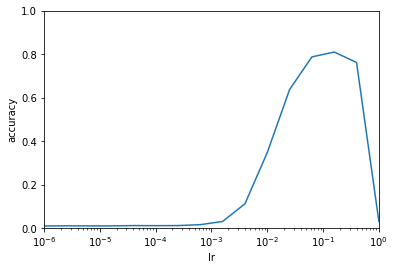

In [6]:
from matplotlib import pyplot as plt

plt.semilogx(his.history['lr'], his.history['accuracy'])
plt.axis([1e-6, 1, 0, 1])
plt.xlabel('lr')
plt.ylabel('accuracy')
plt.show()